# ResNet Ablation Study


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pathlib
import os
import pandas as pd

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


## ResNet 블록 구성하기
ResNet-34와 ResNet-50 네트워크 만들기  
둘의 공통점으로 convolution block을 쌓아서 구조를 만듬  
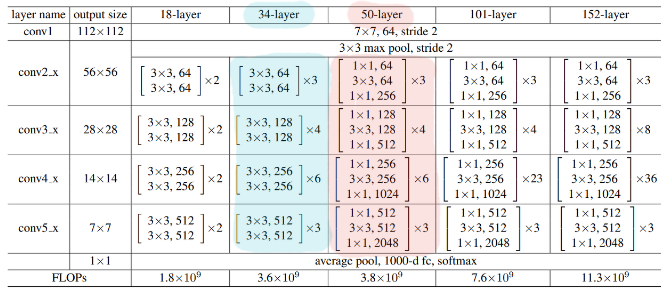
차이점으로는 블록 내부에서 ResNet-34는 3x3 커널로만 이루어져있지만  
ResNet-50은 1x1 커널이 앞뒤로 붙어 더 많은 레이어가 한 블록 안에 있게된다.  
참고 링크 : https://hwanny-yy.tistory.com/12  
skip connection
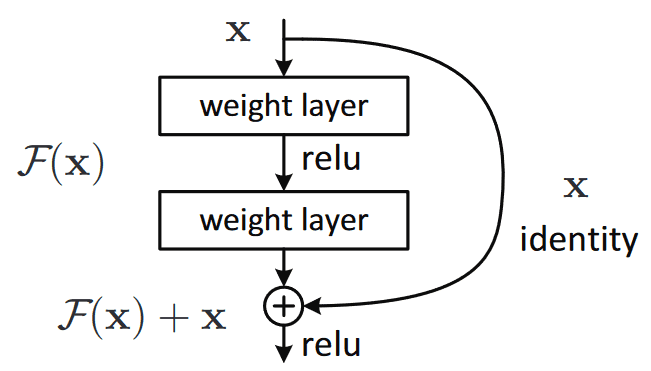

In [2]:
def build_resnet_block(input_layer,
                       num_cnn=3,     
                       channel=64,    
                       block_num=1,   
                       is_50 = False,     # True = ResNet_50, False = Not ResNet_50
                       is_plain = False   # True = no skip connection, False = skip connection
                      ):                   # 기본값은 ResNet_34로 되어있고 is_plain 인자로 skip connection의 여부를 선택
    # 입력 레이어
    x = input_layer
    if not is_50:           # == is_50=False, ResNet_34일 경우 다음 코드 진행
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(   # 첫번째 레이어
                filters = channel,       
                kernel_size = (3,3),     # 필터 크기 3x3
                activation = 'relu',
                kernel_initializer = 'he_normal',
                padding = 'same',
                name = f'block{block_num}_conv{cnn_num}'  
            )(x)
            
            x = keras.layers.BatchNormalization()(x)      # 배치 정규화
            
            x = keras.layers.Conv2D(   # 두번째 레이어
                filters = channel,        
                kernel_size = (3,3),     # 필터 크기 3x3
                activation = 'relu',
                kernel_initializer = 'he_normal',
                padding = 'same',
                name = f'block{block_num}_1_conv{cnn_num}'
            )(x)
            
            if not is_plain:          # == is_plain = False, skip connection 일 경우
                identity_channel = identity.shape.as_list()[-1]   
                # identity(==x)의 행렬 구조를 as_list()로 텐서의 형태에서 리스트로 반환, 그 중 마지막 차원(채널)
            
                if identity_channel != channel:   
                    identity = keras.layers.Conv2D(channel, kernel_size = (1,1), strides = (1,1), padding = 'same')(identity)
                    # 위의 identity_channel이 블록에서 설정한 채널과 다르다면 identity(==x)를 1x1 커널을 통과시켜 채널 수를 맞춰줌
                    
                x = keras.layers.Add()([x, identity])   # skip connection
                
            else:   
                pass    # skip connection이 아니므로 추가 과정 없이 진행
            
    else:   # is_50 = True, ResNet_50 일 경우
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(     # 첫번째 레이어 (1x1)
                filters = channel,        
                kernel_size = (1,1),     # 필터 크기 1x1
                activation='relu',
                kernel_initializer = 'he_normal',
                padding = 'same',
                name = f'block{block_num}_conv{cnn_num}'
            )(x)

            x = keras.layers.BatchNormalization()(x)     # 배치 정규화

            x = keras.layers.Conv2D(     # 두번째 레이어 (3x3)
                filters = channel,
                kernel_size = (3,3),     # 필터 크기 3x3
                activetion = 'relu',
                kernel_initializer = 'he_normal',
                padding = 'same',
                name = f'block{block_num}_1_conv{cnn_num}'
            )(x)

            x = keras.layers.Conv2D(     # 세번째 레이어 (1x1)
                filters = channel * 4,    # 마지막 레이어의 채널 수는 블럭 입력 채널 수의 4배이다
                kernel_size = (1,1),     # 커널 크기 (1x1)
                activation = 'relu',
                kernel_initialzer = 'he_normal',
                padding = 'same',
                name = f'block{block_num}_2_conv{cnn_num}'
            )(x)

            if not is_plain:          # == is_plain = False, skip connection 일 경우
                identity_channel = identity.shape.as_list()[-1]   
                # identity(==x)의 행렬 구조를 as_list()로 텐서의 형태에서 리스트로 반환, 그 중 마지막 차원(채널)

                if identity_channel != channel:   
                    identity = keras.layers.Conv2D(channel, kernel_size = (1,1), strides = (1,1), padding = 'same')(identity)
                    # 위의 identity_channel이 블록에서 설정한 채널과 다르다면 identity(==x)를 1x1 커널을 통과시켜 채널 수를 맞춰줌

                x = keras.layers.Add()([x, identity])   # skip connection

            else:
                pass    # skip connection이 아니므로 추가 과정 없이 진행
                
    # Max Pooling 레이어
    if identity.shape[1] != 1:        # ResNet Block을 거쳐 identity의 사이즈가 벡터화 되기 전까지는 pooling 진행
        x = keras.layers.MaxPooling2D(
            pool_size = (3, 3),
            strides = 2,
            name = f'block{block_num}_pooling'
        )(x)
        
    return x

## ResNet 블록을 쌓기
CIFAR-10 데이터의 크기 (32,32,3)  
ResNet_34, ResNet_50 두 모델 공통으로 각가 블럭 내에서 [3, 4, 6, 3]번씩 레이어 진행  
블럭 별 지정 채널 수 [64, 128, 256, 512]  

In [3]:
def build_resnet(input_shape = (160,160,3),
                num_cnn_list = [3, 4, 6, 3],
                channel_list = [64, 128, 258, 512],
                num_classes = 10,
                is_50 = False,
                is_plain = False):
    assert len(num_cnn_list) == len(channel_list)   
    # assert : 가정 설정문 -> 여기서는 num_cnn_list의 길이와 channel_list의 길이가 같은지 확인. 조건이 틀리다면 Error를 발생시킴
    if is_50:    # == is_50 = True, ResNet_50이 맞을 경우
        num_cnn_list = [3, 4, 6, 3]
        channel_list = [64, 128, 256, 512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape = input_shape) # (32, 32, 3)크기의 인풋 레이어를 만들어준다.
    output = input_layer
    
    # conv 1층
    output = keras.layers.Conv2D(filters = 64,
                                kernel_size = (2, 2),
                                strides = 2,
                                padding = 'valid')(output)
    
    output = keras.layers.BatchNormalization()(output)
    
    # conv2 입력을 위한 pooling
    output = keras.layers.MaxPooling2D(pool_size = (2, 2),
                                      strides = 2,)(output)
    
    
    # config list들의 길이만큼 반복해서 블록을 생성
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        # zip() = 길이가 같은 순회 가능한 객체(iterable) 자료형을 묶어주는 함수. 같은 인덱스끼리 짝별로 묶어 튜플로 반환
        output = build_resnet_block(
            output,
            num_cnn = num_cnn,
            channel = channel,
            block_num = i
        )
        
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name = 'flatten')(output)
    output = keras.layers.Dense(512, activation = 'relu', name = 'fc1')(output)
    output = keras.layers.Dense(num_classes, activation = 'softmax', name = 'predictions')(output)
    
    model = keras.Model(
        inputs = input_layer,
        outputs = output
    )
    
    return model

In [4]:
resnet_34 = build_resnet(is_50 = False)
resnet_50 = build_resnet(is_50 = True)
plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
plain_resnet_50 = build_resnet(is_50 = True, is_plain = False)

In [5]:
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 64)   832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 40, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 80, 80, 64)   832         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 80, 80, 64)   256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 40, 40, 64)   0           batch_normalization_17[0][0]     
____________________________________________________________________________________________

In [7]:
plain_resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 80, 80, 64)   832         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 80, 80, 64)   256         conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 40, 40, 64)   0           batch_normalization_34[0][0]     
____________________________________________________________________________________________

In [8]:
plain_resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 80, 80, 64)   832         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 80, 80, 64)   256         conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 40, 40, 64)   0           batch_normalization_51[0][0]     
____________________________________________________________________________________________

## 데이터셋 로드
tensorflow에서 제공하는 cats_vs_dogs 데이터 사용  
참고 링크 : https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/transfer_learning.ipynb

In [9]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

68616192/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [10]:
print(train_dataset)
print(validation_dataset)

<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>


데이터셋 시각화하여 확인해보기

In [11]:
class_names = train_dataset.class_names

def imgshow(dataset):
    plt.figure(figsize = (10,10))
    for image, label in dataset.take(1):
        for i in range(6):
            ax = plt.subplot(2, 3, i + 1)
            plt.imshow(image[i].numpy().astype('uint8'))
            plt.title(class_names[label[i]])
            plt.axis('off')

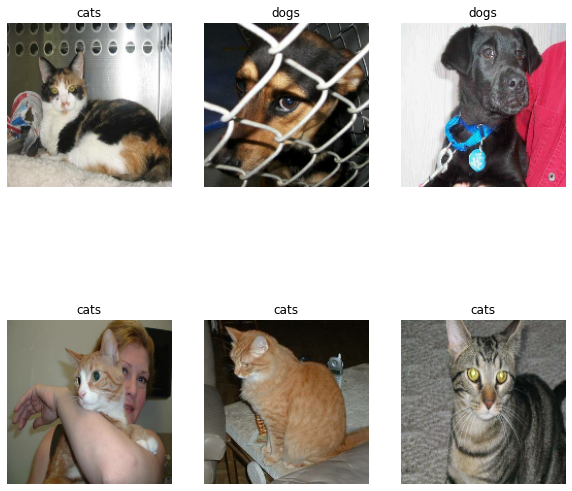

In [12]:
imgshow(train_dataset)

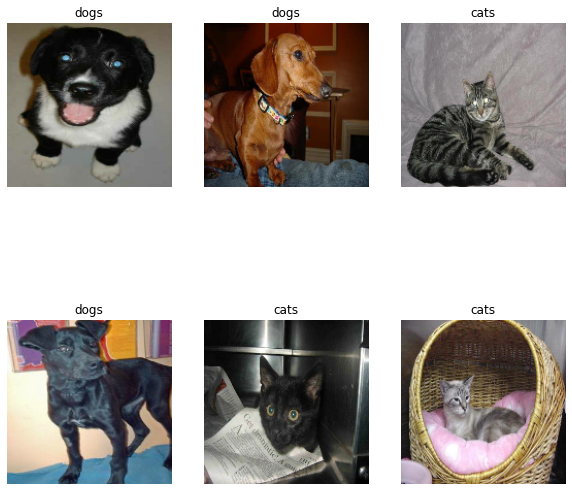

In [13]:
imgshow(validation_dataset)

원본 데이터셋에 없는 테스트 데이터셋 생성  
tf.data.experimental.cardinality 를 사용하여 검증 데이터셋에서 사용할 수 있는 데이터 배치 수를 확인하고  
그 중 20%를 테스트 데이터셋으로 이동

In [14]:
val_batches = tf.data.experimental.cardinality(validation_dataset)  # validation_dataset의 배치 사이즈 확인
test_dataset = validation_dataset.take(val_batches // 5)          # 배치 사이즈의 20%를 테스트 데이터로 할당
validation_dataset = validation_dataset.skip(val_batches // 5)    # 배치 사이즈의 20%를 검증 데이터셋에서 제거(테스트와의 중복)

In [15]:
print(tf.data.experimental.cardinality(train_dataset))        # train_dataset의 배치 사이즈
print(tf.data.experimental.cardinality(validation_dataset))   # validation_dataset의 배치 사이즈
print(tf.data.experimental.cardinality(test_dataset))         # test_dateset의 배치 사이즈

tf.Tensor(63, shape=(), dtype=int64)
tf.Tensor(26, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)


In [21]:
print(class_names)

['cats', 'dogs']


### input data 정규화
data normalization을 하여 이미지 픽셀 정보를 0-255 에서 0-1사이의 값으로 만든다

In [16]:
def normalize_and_resize_img(image, label):
    '''Normalize image : "uint8" -> "float32" '''
    return tf.cast(image, tf.float32) / 255. , label

In [17]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls = 1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds =ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [32]:
BATCH_SIZE = 256
EPOCH = 20

In [35]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split = ['train', 'test'],
    as_supervised = True,
    shuffle_files = True,
    with_info = True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size = BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size = BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

DownloadError: Failed to get url https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip. HTTP code: 404.

In [26]:
# ds_train = apply_normalize_on_dataset(train_dataset, batch_size=32)
# ds_val = apply_normalize_on_dataset(validation_dataset, batch_size=32)
# ds_test = apply_normalize_on_dataset(test_dataset, batch_size=32)

### 모델 훈련

In [31]:
resnet_34.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    step_per_epoch = int(ds_info.splits['train'].num_examples/32),
    validation_steps = int(ds_info.splits['val'].num_examples/32),
    epochs = 20,
    validation_data = ds_test,
    vervose = 1,
    use_multiprocessing = True,
)

NameError: name 'ds_info' is not defined